# **Australian Credit Risk Dataset Analysis** 

The dataset concerns credit card applications. The simple idea is given a credit card application, should it be rejected (0) or approved (1) based on customer details and other paramters.

# **Subprocess**
---
The subprocess module allows you to spawn new processes, connect to their input/output/error pipes, and obtain their return codes.

### `check_output()`

Run command with arguments and return its output.

If the return code was non-zero it raises a CalledProcessError. The CalledProcessError object will have the return code in the returncode attribute and any output in the output attribute.

In [9]:
import subprocess
print((subprocess.check_output("lscpu", shell=True).strip()).decode())

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.116
BogoMIPS:            4400.23
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

# **Imports**
---

Import all libraries and packages needed for the analysis. Common classification models from sklearn are also choosen along with other packages for exploration and preprocessing.

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kstest
from sklearn.preprocessing import normalize
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split,GridSearchCV, ShuffleSplit, StratifiedShuffleSplit, LeaveOneOut
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [11]:
# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# **Dataset** 
---

We **read** and **describe** the Australian Credit Dataset taken from [UCI](https://archive.ics.uci.edu/ml/datasets/statlog+(australian+credit+approval). The dataset file concerns credit card applications and their acceptances or rejections.

We read the data from [australian.dat](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat) file.

In [12]:
df=pd.read_table('https://drive.google.com/uc?id=1nfomX-OWLDVa4FjmDLzr8vx_FPENH07N&export=download',sep='\s+',header=None)
df.columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','Y']

In [13]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,Y
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


**Dataset Information:**

All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. The source of data has also been kept confedential. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      690 non-null    int64  
 1   X2      690 non-null    float64
 2   X3      690 non-null    float64
 3   X4      690 non-null    int64  
 4   X5      690 non-null    int64  
 5   X6      690 non-null    int64  
 6   X7      690 non-null    float64
 7   X8      690 non-null    int64  
 8   X9      690 non-null    int64  
 9   X10     690 non-null    int64  
 10  X11     690 non-null    int64  
 11  X12     690 non-null    int64  
 12  X13     690 non-null    int64  
 13  X14     690 non-null    int64  
 14  Y       690 non-null    int64  
dtypes: float64(3), int64(12)
memory usage: 81.0 KB


In [15]:
# Get descriptive statistics of the data
df.describe(include="all")

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,Y
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,0.678261,31.568203,4.758725,1.766667,7.372464,4.692754,2.223406,0.523188,0.427536,2.40000,0.457971,1.928986,184.014493,1018.385507,0.444928
std,0.467482,11.853273,4.978163,0.430063,3.683265,1.992316,3.346513,0.499824,0.495080,4.86294,0.498592,0.298813,172.159274,5210.102598,0.497318
min,0.000000,13.750000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,22.670000,1.000000,2.000000,4.000000,4.000000,0.165000,0.000000,0.000000,0.00000,0.000000,2.000000,80.000000,1.000000,0.000000
50%,1.000000,28.625000,2.750000,2.000000,8.000000,4.000000,1.000000,1.000000,0.000000,0.00000,0.000000,2.000000,160.000000,6.000000,0.000000
75%,1.000000,37.707500,7.207500,2.000000,10.000000,5.000000,2.625000,1.000000,1.000000,3.00000,1.000000,2.000000,272.000000,396.500000,1.000000
max,1.000000,80.250000,28.000000,3.000000,14.000000,9.000000,28.500000,1.000000,1.000000,67.00000,1.000000,3.000000,2000.000000,100001.000000,1.000000


**Attribute Information:**

There are **6 numerical** and **8 categorical** attributes. The labels have been changed for the convenience of the statistical algorithms. For example, attribute 4 originally had 3 labels p,g,gg and these have been changed to labels 1,2,3.

* **X1**: 0,1 CATEGORICAL (formerly: a,b)
* **X2**: continuous.
* **X3**: continuous.
* **X4**: 1,2,3 CATEGORICAL (formerly: p,g,gg)
* **X5**: 1, 2,3,4,5, 6,7,8,9,10,11,12,13,14 CATEGORICAL (formerly: ff,d,i,k,j,aa,m,c,w, e, q, r,cc, x)
* **X6**: 1, 2,3, 4,5,6,7,8,9 CATEGORICAL (formerly: ff,dd,j,bb,v,n,o,h,z)
* **X7**: continuous.
* **X8**: 1, 0 CATEGORICAL (formerly: t, f)
* **X9**: 1, 0 CATEGORICAL (formerly: t, f)
* **X10**: continuous.
* **X11**: 1, 0 CATEGORICAL (formerly t, f)
* **X12**: 1, 2, 3 CATEGORICAL (formerly: s, g, p)
* **X13**: continuous.
* **X14**: continuous.
* **Y**: 1,2 class attribute (formerly: +,-)



In [16]:
# Number of unique vaules in each column
df.nunique()

X1       2
X2     350
X3     215
X4       3
X5      14
X6       8
X7     132
X8       2
X9       2
X10     23
X11      2
X12      3
X13    171
X14    240
Y        2
dtype: int64

In [17]:
# Any null values
df.isnull().sum()

X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
Y      0
dtype: int64

In [18]:
# Splitting the dataframe into categorial and continuous parameters.
df_cat=df[['X1','X4','X5','X6','X8','X9','X11','X12','Y']]
df_cont=df[['X2','X3','X7','X10','X13','X14','Y']]

In [19]:
df_cont.describe()

,X2,X3,X7,X10,X13,X14,Y
count,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000
mean,31.568203,4.758725,2.223406,2.40000,184.014493,1018.385507,0.444928
std,11.853273,4.978163,3.346513,4.86294,172.159274,5210.102598,0.497318
min,13.750000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
25%,22.670000,1.000000,0.165000,0.00000,80.000000,1.000000,0.000000
50%,28.625000,2.750000,1.000000,0.00000,160.000000,6.000000,0.000000
75%,37.707500,7.207500,2.625000,3.00000,272.000000,396.500000,1.000000
max,80.250000,28.000000,28.500000,67.00000,2000.000000,100001.000000,1.000000


# **Exploration**
---

Now we will do some data exploration and make a few plots.


### Class Ratio

Plot to see how many credit applications were **accpeted** vs how many were **rejected**.

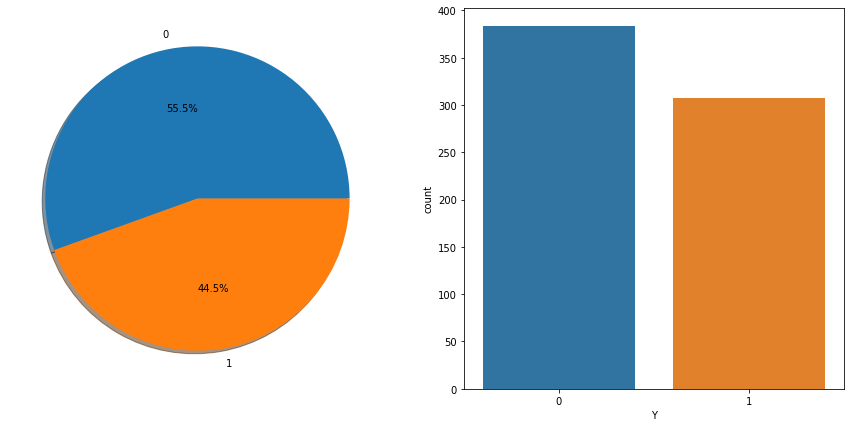

In [20]:
# Compare 0s vs 1s in the class attribute
f,ax=plt.subplots(1,2,figsize=(15,7))

df['Y'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)

ax[0].set_ylabel('')
sns.countplot('Y',x=None, y=None, data=df,ax=ax[1])
plt.show()

### Correlation Matrix

Display the correlation coefficients for different attributes. The matrix depicts the correlation between all the possible pairs of values in a table.

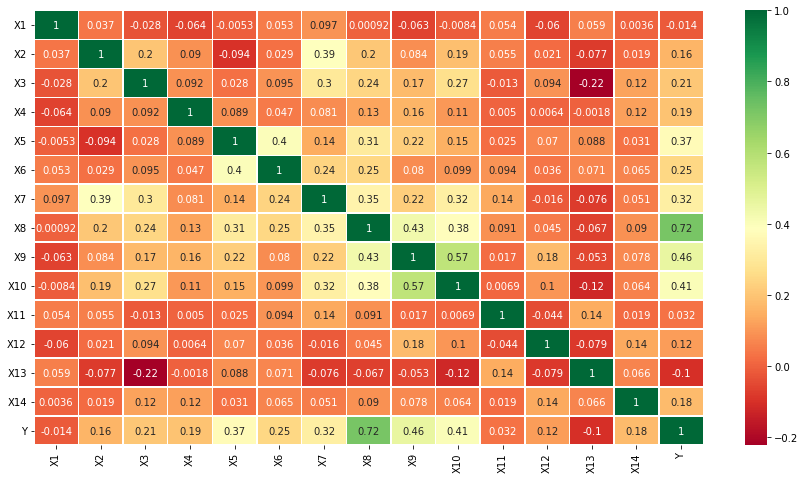

In [21]:
# Plot the correlation matrix as a heatmap
sns.heatmap(df.corr(),linewidths=.5,annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.show()

### Distribution Plot

Make distribution plots for the continuous attributes.

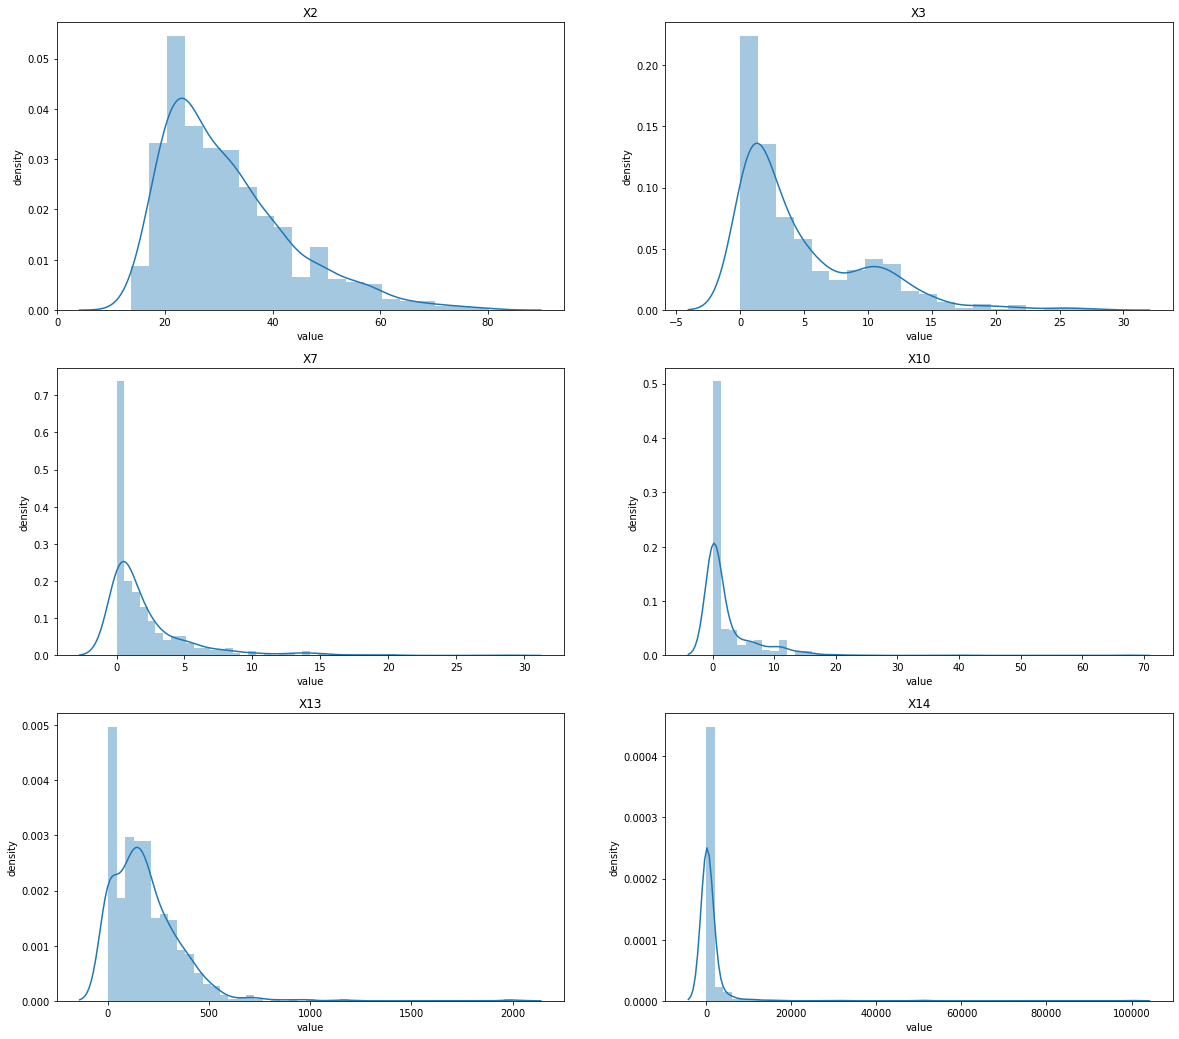

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,18))
feature_index = 0
for ii in range(3):
    for jj in range(2):
        ax = sns.distplot(df_cont.iloc[:, feature_index], ax=axes[ii,jj])
        ax.set(title=df_cont.columns.values[feature_index], xlabel="value",ylabel="density")      
        feature_index += 1
plt.show()

### Normality Test

Performs the one-sample Kolmogorov-Smirnov test for goodness of fit.

The one-sample test compares the underlying distribution F(x) of a sample against a given distribution G(x).

In [23]:
KStestResults= []
for ii in range(len(df_cont.columns)):
    KStestResults.append(kstest(df.iloc[:,ii], 'norm'))
KStestResults

[KstestResult(statistic=0.5196056156337603, pvalue=8.730967774462497e-174),
 KstestResult(statistic=1.0, pvalue=0.0),
 KstestResult(statistic=0.6172507697456346, pvalue=1.1406941430897084e-253),
 KstestResult(statistic=0.8413447460685429, pvalue=0.0),
 KstestResult(statistic=0.9004382738489223, pvalue=0.0),
 KstestResult(statistic=0.9073457541422829, pvalue=0.0),
 KstestResult(statistic=0.5, pvalue=4.910350530309684e-160)]

### Boxplot

Make boxplots for the continuous attributes to get a good indication of how the values in the data are spread out.

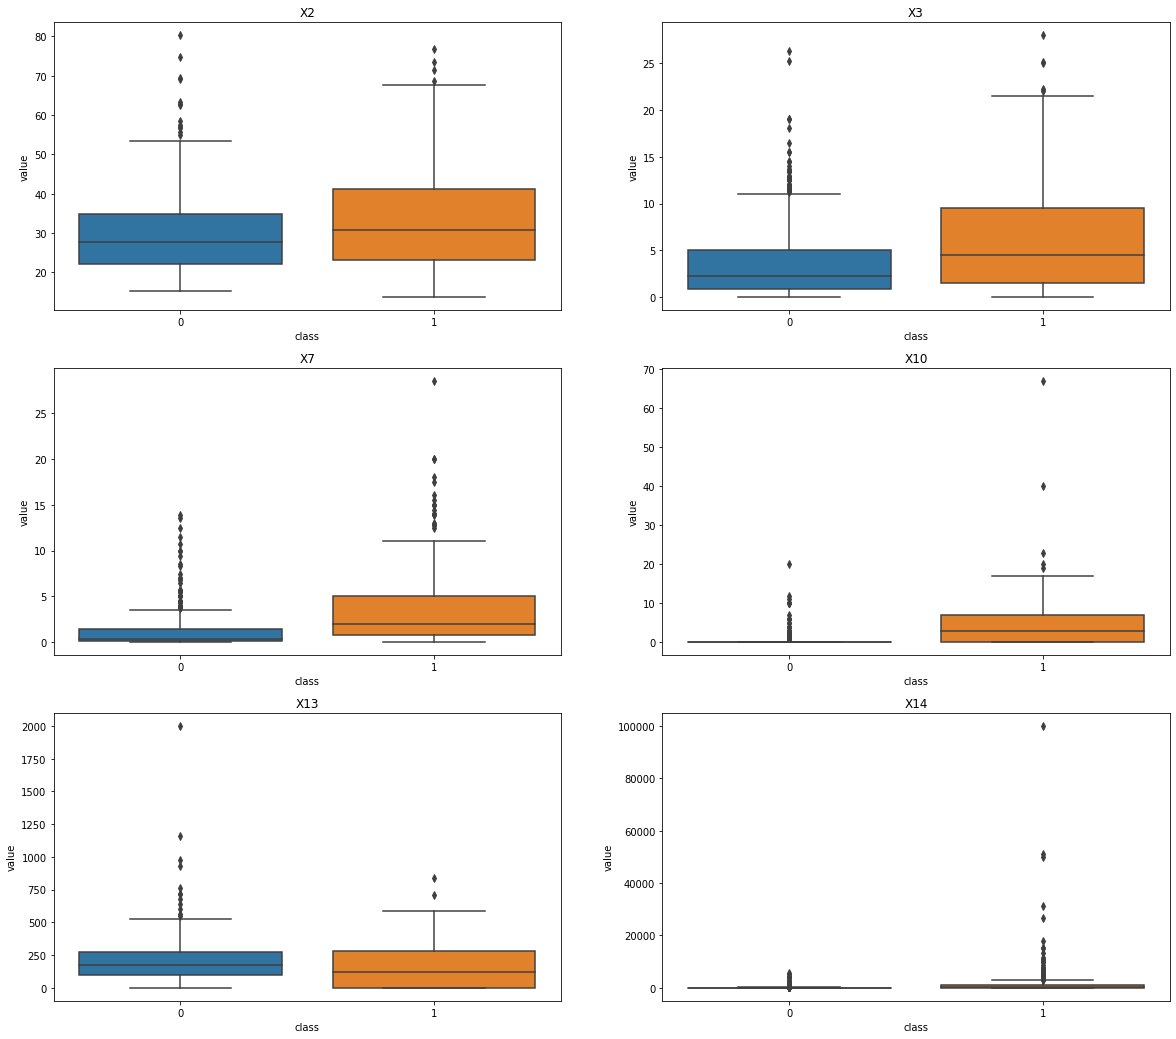

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,18))
feature_index = 0
for ii in range(3):
    for jj in range(2):
        ax = sns.boxplot(x=df_cont.Y, y=df_cont.columns.values[feature_index], data=df_cont, ax=axes[ii,jj])
        ax.set(title=df_cont.columns.values[feature_index], xlabel="class", ylabel="value")
        feature_index += 1
plt.show()

### Swarmplot

See the spread of Y = 0 and 1 values for the categorial attributes using a swarm plot.

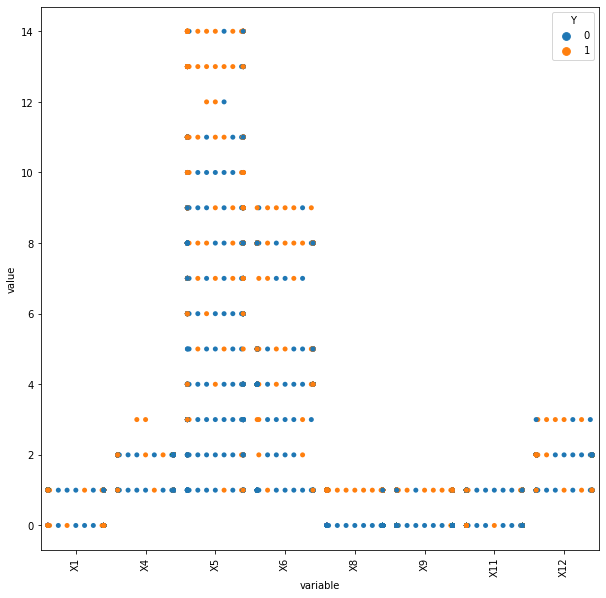

In [25]:
dff2=pd.melt(df_cat,id_vars='Y')
sns.swarmplot(x="variable", y="value", hue="Y", data=dff2)
plt.xticks(rotation=90)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

# **Preprocessing**
---

We are now ready to preprocess the data before feature and model selection.

In [26]:
# Drop 'Y' column from df, df_cont and df_cat and then make a new df - y
x=df.drop('Y',axis=1)
x_cont=df_cont.drop('Y', axis=1)
x_cat=df_cat.drop('Y',axis=1)
y=df['Y']

### Feature Selection

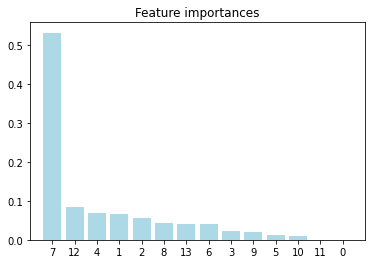

In [27]:
# Decide feature importance using DecisionTreeClassifier
pohon=DecisionTreeClassifier(class_weight='balanced',random_state=15)
pohom = pohon.fit(x, y)
importances=pohon.feature_importances_

indices = np.argsort(importances)[::-1]

plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],color='lightblue')
plt.xticks(range(x.shape[1]), indices)
plt.xlim([-1, x.shape[1]])
plt.show()

In [28]:
pohon.feature_importances_

# Meta-transformer for selecting features based on importance weights.
# Transforms x to x_new, with attributes based on importance, using median as a thershold.
fs = SelectFromModel(pohon, threshold = 'median', prefit=True)
x_new = fs.transform(x)

x_new=pd.DataFrame(x_new)
x_new.head()

,0,1,2,3,4,5,6
0,22.08,11.46,4.0,0.0,0.0,100.0,1213.0
1,22.67,7.00,8.0,0.0,0.0,160.0,1.0
2,29.58,1.75,4.0,0.0,0.0,280.0,1.0
3,21.67,11.50,5.0,1.0,1.0,0.0,1.0
4,20.17,8.17,6.0,1.0,1.0,60.0,159.0


### Dummy For Categorical Features

In [29]:
# Create dummies for categorial features.
x_dummy=pd.get_dummies(x_new[[2,3,4]], columns=[2,3,4])
x_dummy.head()

,2_1.0,2_2.0,2_3.0,2_4.0,2_5.0,2_6.0,2_7.0,2_8.0,2_9.0,2_10.0,2_11.0,2_12.0,2_13.0,2_14.0,3_0.0,3_1.0,4_0.0,4_1.0
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1


### Normalization

Scale input vectors individually to unit norm (vector length).

In [30]:
# Perform a row normalization on the conitnuous data
x_norm = pd.DataFrame(normalize(x_new[[0,1,5,6]]))
x_norm.head()

,0,1,2,3
0,0.018137,0.009414,0.082144,0.996411
1,0.140152,0.043276,0.989164,0.006182
2,0.105056,0.006215,0.994441,0.003552
3,0.882589,0.468379,0.000000,0.040729
4,0.117725,0.047685,0.350198,0.928024


### PCA

A statistical procedure that uses an orthogonal transformation that converts a set of correlated variables to a set of uncorrelated variables.

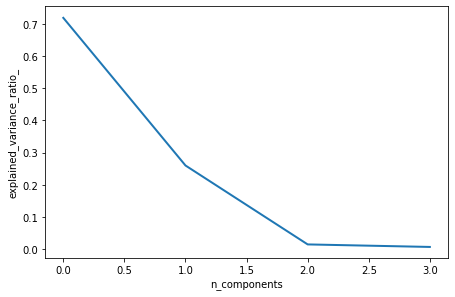

In [31]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_norm)

plt.figure(1, figsize=(8, 5))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
plt.show()

In [32]:
pca = PCA(n_components=2)
x_pca=pca.fit_transform(x_norm)

In [33]:
x_pca=pd.DataFrame(x_pca)
x_pca = pd.concat([x_pca, x_dummy],axis=1)
x_pca.head()

,0,1,2_1.0,2_2.0,2_3.0,2_4.0,2_5.0,2_6.0,2_7.0,2_8.0,2_9.0,2_10.0,2_11.0,2_12.0,2_13.0,2_14.0,3_0.0,3_1.0,4_0.0,4_1.0
0,0.819294,-0.158148,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,-0.527039,-0.080555,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
2,-0.531070,-0.113969,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,0.153018,1.001204,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
4,0.579835,-0.175551,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1


# Model

### Repeated Holdout

In [34]:
ss = ShuffleSplit(n_splits=10, test_size=0.33,random_state=10)
models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('Logistic Regression', LogisticRegression()))
models.append(('MLP', MLPClassifier (max_iter=1000)))

results = []
names = []
table=[]
for name, model in models:
    accuracy=cross_val_score(model, x_pca, y, cv=ss)
    results.append(accuracy.mean())
    names.append(name)
table=pd.DataFrame({'Accuracy':results},index=names).sort_values('Accuracy',ascending=False)
table

,Accuracy
Logistic Regression,0.870614
SVM,0.864474
KNN,0.860526
Gradient Boosting,0.855702
MLP,0.851754
Random Forest,0.846930
Naive Bayes,0.812281
CART,0.810965


### Stratified Repeated Holdout

In [35]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.33,random_state=11)
models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('Logistic Regression', LogisticRegression()))
models.append(('MLP', MLPClassifier (max_iter=1000)))

results = []
names = []
table=[]
for name, model in models:
    accuracy=cross_val_score(model, x_pca, y, cv=sss)
    results.append(accuracy.mean())
    names.append(name)
table=pd.DataFrame({'Accuracy':results},index=names).sort_values('Accuracy',ascending=False)
table

,Accuracy
Logistic Regression,0.856579
SVM,0.855263
MLP,0.850439
KNN,0.849123
Random Forest,0.848246
Gradient Boosting,0.843860
CART,0.803947
Naive Bayes,0.775439


### Randomized Kfold

In [36]:
kfold=KFold(n_splits=10, shuffle=True, random_state=12)
models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('Logistic Regression', LogisticRegression()))
models.append(('MLP', MLPClassifier (max_iter=1000)))

results = []
names = []
table=[]
for name, model in models:
    accuracy=cross_val_score(model, x_pca, y, cv=kfold)
    results.append(accuracy.mean())
    names.append(name)
table=pd.DataFrame({'Accuracy':results},index=names).sort_values('Accuracy',ascending=False)
table

,Accuracy
Logistic Regression,0.871014
KNN,0.868116
SVM,0.868116
MLP,0.853623
Gradient Boosting,0.852174
Random Forest,0.849275
Naive Bayes,0.821739
CART,0.801449


### Stratified Kfold

In [37]:
skfold=StratifiedKFold(n_splits=10, shuffle=True, random_state=13)
models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('Logistic Regression', LogisticRegression()))
models.append(('MLP', MLPClassifier (max_iter=1000)))

results = []
names = []
table=[]
for name, model in models:
    accuracy=cross_val_score(model, x_pca, y, cv=skfold)
    results.append(accuracy.mean())
    names.append(name)
table=pd.DataFrame({'Accuracy':results},index=names).sort_values('Accuracy',ascending=False)
table

,Accuracy
KNN,0.872464
Logistic Regression,0.869565
SVM,0.863768
Gradient Boosting,0.859420
MLP,0.855072
Random Forest,0.852174
Naive Bayes,0.813043
CART,0.808696


### Leave One Out

In [38]:
lvo=LeaveOneOut()
models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('Logistic Regression', LogisticRegression()))
models.append(('MLP', MLPClassifier ()))

results = []
names = []
table=pd.DataFrame({'Accuracy':results},index=names).sort_values('Accuracy',ascending=False)
table=[]
for name, model in models:
    accuracy=cross_val_score(model, x_pca, y, cv=lvo)
    results.append(accuracy.mean())
    names.append(name)
table=pd.DataFrame({'Accuracy':results},index=names).sort_values('Accuracy',ascending=False)
table

,Accuracy
KNN,0.873913
SVM,0.873913
Logistic Regression,0.869565
MLP,0.859420
Random Forest,0.856522
Gradient Boosting,0.855072
Naive Bayes,0.836232
CART,0.800000


# Parameter Tuning

### Decision Tree

In [39]:
parameter={
    'max_depth': [None, 2, 3, 4, 5, 6, 7],
    'min_samples_split' : np.arange(2,202,20),
    'min_samples_leaf' : np.arange(1,201,20),
    'max_leaf_nodes': (None, 2, 5, 10, 20, 50),
    'class_weight': ['balanced', None]
}
grid=GridSearchCV(DecisionTreeClassifier(), parameter, verbose=1, n_jobs=-1)
gridfit=grid.fit(x_pca,y)
gridfit.best_params_

Fitting 5 folds for each of 8400 candidates, totalling 42000 fits


{'class_weight': 'balanced',
 'max_depth': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 21,
 'min_samples_split': 2}

### SVM

In [40]:
parameter = [
  {'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear']},
  {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [ 0.01, 1], 'kernel': ['rbf','poly']},
 ]
grid=GridSearchCV(SVC(cache_size=1000), parameter, verbose=1, n_jobs=-1)
gridfit=grid.fit(x_pca,y)
gridfit.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


{'C': 0.01, 'gamma': 1, 'kernel': 'poly'}

### Logistic Regression

In [41]:
parameter={
    'penalty': ['l1', 'l2'],
    'C': [0.1, 0.3, 0.5, 0.8,1],
    'class_weight':['balanced', None]
    }
grid=GridSearchCV(LogisticRegression(), parameter,n_jobs=-1, verbose=1)
gridfit=grid.fit(x_pca,y)
gridfit.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'C': 0.3, 'class_weight': None, 'penalty': 'l2'}

### Random Forest

In [42]:
parameter={
    'max_depth': [2,3,5,7,10,None],
    'min_samples_leaf': [1,10,30,60],
    'max_features': [1.0,'log2','sqrt','auto',None],
    'n_estimators': [1,2,3,5,10]
    }
grid=GridSearchCV(RandomForestClassifier(), parameter,n_jobs=-1, verbose=1)
gridfit=grid.fit(x_pca,y)
gridfit.best_params_

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


{'max_depth': 5,
 'max_features': 1.0,
 'min_samples_leaf': 10,
 'n_estimators': 10}

### Gradient Boosting

In [43]:
parameter={
    'learning_rate': [0.01, 0.03, 0.05, 0.1,1],
    'max_depth': [2,3,5,7,10,100],
    'min_samples_leaf': [1,10,30,60,100,200],
    'max_features': ['log2','sqrt','auto',None],
    'n_estimators': [1,2,3,10,50,100]
    }
grid=GridSearchCV(GradientBoostingClassifier(), parameter,n_jobs=-1, verbose=1)
gridfit=grid.fit(x_pca,y)
gridfit.best_params_

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


{'learning_rate': 1,
 'max_depth': 2,
 'max_features': 'auto',
 'min_samples_leaf': 100,
 'n_estimators': 10}

### KNN

In [44]:
parameter={
    'n_neighbors': [5,10,20,50,100], 
    'weights': ['uniform','distance']
    }
grid=GridSearchCV(KNeighborsClassifier(), parameter,n_jobs=-1,verbose=1)
gridfit=grid.fit(x_pca,y)
gridfit.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_neighbors': 5, 'weights': 'uniform'}

### MLP

In [45]:
parameter={
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1]
    }
grid=GridSearchCV(MLPClassifier(max_iter=1000), parameter,n_jobs=-1, verbose=1)
gridfit=grid.fit(x_pca,y)
gridfit.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


{'activation': 'identity',
 'alpha': 0.1,
 'learning_rate': 'constant',
 'learning_rate_init': 0.001}

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.3, random_state=42)

In [47]:
# Sanity check for the sampled data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(483, 20)
(483,)
(207, 20)
(207,)


## **Classifier 1 - Decision Tree Classifier**

In [50]:
clf = DecisionTreeClassifier(class_weight='balanced', max_depth=None, max_leaf_nodes=None, min_samples_leaf=21, min_samples_split=2)
dtree=clf.fit(X_train,y_train)
prediction=dtree.predict(X_test)

In [51]:
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       126
           1       0.83      0.83      0.83        81

    accuracy                           0.86       207
   macro avg       0.86      0.86      0.86       207
weighted avg       0.86      0.86      0.86       207

[[112  14]
 [ 14  67]]
Accuracy of the model on Testing Sample Data: 0.86


In [55]:
# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running Cross validation

Accuracy_Values=cross_val_score(dtree, x_pca , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.870115   0.8977597  0.86978738 0.89867955 0.89837793 0.92706983
 0.78306569 0.81199026 0.94215139 0.78315847]

Final Average Accuracy of the model: 0.87


In [53]:
#Calculating roc_auc_score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test ,prediction) 

0.8580246913580247

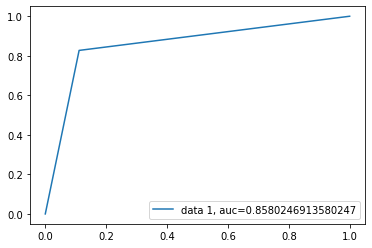

In [54]:
from sklearn.metrics import roc_curve
pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  prediction)
auc = roc_auc_score(y_test, prediction)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## **Classifier 2 - KNeighboursClassifier**



In [56]:
clf = KNeighborsClassifier(n_neighbors=20, weights='uniform')
model=clf.fit(X_train,y_train)
prediction=model.predict(X_test)

In [57]:
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       126
           1       0.87      0.84      0.86        81

    accuracy                           0.89       207
   macro avg       0.89      0.88      0.88       207
weighted avg       0.89      0.89      0.89       207

[[116  10]
 [ 13  68]]
Accuracy of the model on Testing Sample Data: 0.89


In [59]:
# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running Cross validation

Accuracy_Values=cross_val_score(model, x_pca , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.87006211 0.92697121 0.81231194 0.88361204 0.88295852 0.91221889
 0.79752987 0.85507246 0.88405797 0.81038155]

Final Average Accuracy of the model: 0.86


In [58]:
#Calculating roc_auc_score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test ,prediction) 

0.8800705467372134

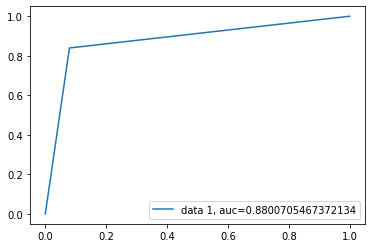

In [60]:
from sklearn.metrics import roc_curve
pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  prediction)
auc = roc_auc_score(y_test, prediction)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## **Classifier 3 - Gaussian Naive Bayes**



In [61]:
clf = GaussianNB()
model=clf.fit(X_train,y_train)
prediction=model.predict(X_test)

In [62]:
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       126
           1       0.84      0.78      0.81        81

    accuracy                           0.86       207
   macro avg       0.85      0.84      0.85       207
weighted avg       0.85      0.86      0.85       207

[[114  12]
 [ 18  63]]
Accuracy of the model on Testing Sample Data: 0.85


In [63]:
# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running Cross validation

Accuracy_Values=cross_val_score(model, x_pca , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.86978738 0.92642507 0.76909518 0.83850797 0.85507246 0.89837793
 0.69629196 0.72921366 0.78306569 0.82608696]

Final Average Accuracy of the model: 0.82


In [64]:
#Calculating roc_auc_score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test ,prediction) 

0.8412698412698412

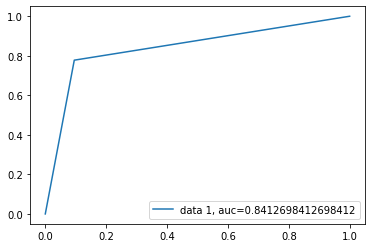

In [65]:
from sklearn.metrics import roc_curve
pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  prediction)
auc = roc_auc_score(y_test, prediction)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## **Classifier 4 - Support Vector Machines**



In [72]:
clf = SVC(C=0.01,kernel='linear', probability=True)
model=clf.fit(X_train,y_train)
prediction=model.predict(X_test)

In [73]:
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       126
           1       0.76      0.91      0.83        81

    accuracy                           0.85       207
   macro avg       0.85      0.86      0.85       207
weighted avg       0.87      0.85      0.85       207

[[102  24]
 [  7  74]]
Accuracy of the model on Testing Sample Data: 0.85


In [74]:
# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running Cross validation

Accuracy_Values=cross_val_score(model, x_pca , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.85562143 0.91304348 0.76850566 0.86983941 0.88420412 0.89867955
 0.79582052 0.81199026 0.91315309 0.84057971]

Final Average Accuracy of the model: 0.86


In [75]:
#Calculating roc_auc_score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test ,prediction) 

0.8615520282186949

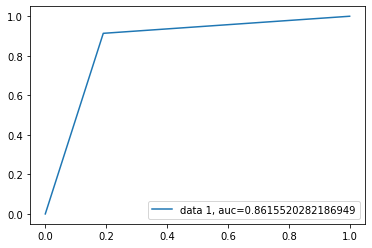

In [76]:
from sklearn.metrics import roc_curve
pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  prediction)
auc = roc_auc_score(y_test, prediction)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## **Classifier 5 - Random Forest Classifier**



In [77]:
clf = RandomForestClassifier(max_depth= 2, n_estimators= 10, min_samples_leaf= 10, max_features= 'auto')
model=clf.fit(X_train,y_train)
prediction=model.predict(X_test)

In [78]:
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       126
           1       0.86      0.83      0.84        81

    accuracy                           0.88       207
   macro avg       0.88      0.87      0.87       207
weighted avg       0.88      0.88      0.88       207

[[115  11]
 [ 14  67]]
Accuracy of the model on Testing Sample Data: 0.88


In [79]:
# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running Cross validation

Accuracy_Values=cross_val_score(model, x_pca , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.85562143 0.92697121 0.85507246 0.86983941 0.85369815 0.89867955
 0.79582052 0.81199026 0.91315309 0.84091484]

Final Average Accuracy of the model: 0.86


In [80]:
#Calculating roc_auc_score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test ,prediction) 

0.8699294532627866

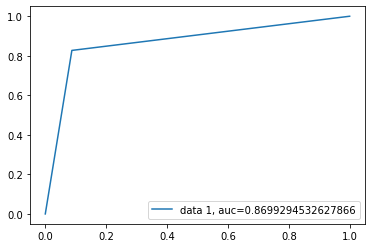

In [81]:
from sklearn.metrics import roc_curve
pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  prediction)
auc = roc_auc_score(y_test, prediction)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## **Classifier 6 - Gradient Boosting Classifier**



In [82]:
clf = GradientBoostingClassifier(learning_rate=0.05, max_depth= 2, n_estimators= 50, min_samples_leaf= 30, max_features= 'auto')
model=clf.fit(X_train,y_train)
prediction=model.predict(X_test)

In [83]:
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       126
           1       0.80      0.86      0.83        81

    accuracy                           0.86       207
   macro avg       0.86      0.86      0.86       207
weighted avg       0.87      0.86      0.87       207

[[109  17]
 [ 11  70]]
Accuracy of the model on Testing Sample Data: 0.87


In [84]:
# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running Cross validation

Accuracy_Values=cross_val_score(model, x_pca , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.870115   0.91263118 0.82682139 0.89867955 0.89837793 0.92706983
 0.79752987 0.85537848 0.94215139 0.79710145]

Final Average Accuracy of the model: 0.87


In [85]:
#Calculating roc_auc_score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test ,prediction) 

0.8646384479717812

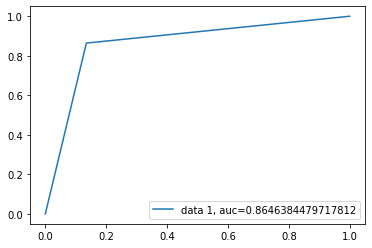

In [86]:
from sklearn.metrics import roc_curve
pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  prediction)
auc = roc_auc_score(y_test, prediction)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## **Classifier 7 - Logistic Regression**



In [87]:
clf = LogisticRegression(penalty= 'l2', class_weight= 'balanced', C= 0.5)
model=clf.fit(X_train,y_train)
prediction=model.predict(X_test)

In [88]:
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       126
           1       0.80      0.89      0.84        81

    accuracy                           0.87       207
   macro avg       0.86      0.87      0.87       207
weighted avg       0.87      0.87      0.87       207

[[108  18]
 [  9  72]]
Accuracy of the model on Testing Sample Data: 0.87


In [89]:
# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running Cross validation

Accuracy_Values=cross_val_score(model, x_pca , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.870115   0.92697121 0.76850566 0.88430278 0.88435075 0.91270903
 0.7826087  0.85537848 0.94217538 0.82652613]

Final Average Accuracy of the model: 0.87


In [90]:
#Calculating roc_auc_score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test ,prediction) 

0.873015873015873

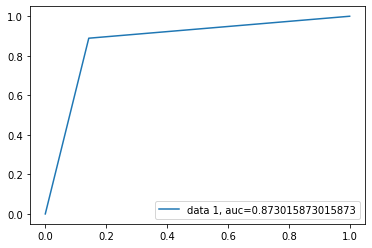

In [91]:
from sklearn.metrics import roc_curve
pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  prediction)
auc = roc_auc_score(y_test, prediction)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## **Classifier 8 - MLP Classifier**



In [92]:
clf = MLPClassifier (max_iter=1000,learning_rate= 'constant', activation= 'tanh', learning_rate_init= 0.1, alpha= 0.1)
model=clf.fit(X_train,y_train)
prediction=model.predict(X_test)

In [93]:
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       126
           1       0.84      0.85      0.85        81

    accuracy                           0.88       207
   macro avg       0.87      0.87      0.87       207
weighted avg       0.88      0.88      0.88       207

[[113  13]
 [ 12  69]]
Accuracy of the model on Testing Sample Data: 0.88


In [94]:
# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running Cross validation

Accuracy_Values=cross_val_score(model, x_pca , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.88440245 0.94137252 0.88274504 0.86989508 0.82608696 0.89723235
 0.78120948 0.85507246 0.89867955 0.81207068]

Final Average Accuracy of the model: 0.86


In [95]:
#Calculating roc_auc_score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test ,prediction) 

0.8743386243386243

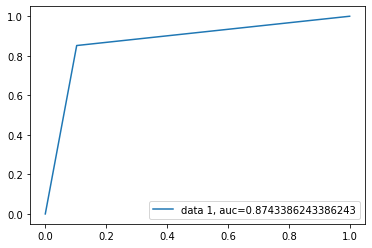

In [96]:
from sklearn.metrics import roc_curve
pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  prediction)
auc = roc_auc_score(y_test, prediction)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# **Classify using COBRA**

Now we can combine the 8 machines above using COBRA and make classificaiton.

In [97]:
# Retraining the model using 100% data
# Using the COBRA algorithm with advanced set of machine lists (combining all the above machines).
import classifiercobra

clf = classifiercobra.ClassifierCobra(machine_list="advanced")
clf

ClassifierCobra(machine_list='advanced')

In [100]:
# Training the model on 100% Data available
cobra_model = clf.fit(x_pca, y)

In [108]:
# Cross validating the final model accuracy with less predictors
# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score
Accuracy_Values = cross_val_score(cobra_model, x_pca, y, cv=10, scoring="f1_weighted")
print("\nAccuracy values for 10-fold Cross Validation:\n", Accuracy_Values)
print("\nFinal Average Accuracy of the model:", round(Accuracy_Values.mean(), 4))


Accuracy values for 10-fold Cross Validation:
 [0.91308001 0.91270903 0.8400908  0.86939959 0.80870518 0.91270903
 0.71872629 0.86945526 0.88361204 0.82476472]

Final Average Accuracy of the model: 0.8553


# Model Best Parameter

### Randomize Repeated Holdout

In [103]:
ss = ShuffleSplit(n_splits=10, test_size=0.33, random_state=10)
models = []
models.append(('CART', DecisionTreeClassifier(class_weight='balanced', max_depth=None, max_leaf_nodes=None, min_samples_leaf=21, min_samples_split=2)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=20, weights='uniform')))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC(C=0.01,kernel='linear')))
models.append(('Random Forest', RandomForestClassifier(max_depth= 2, n_estimators= 10, min_samples_leaf= 10, max_features= 'auto')))
models.append(('Gradient Boosting', GradientBoostingClassifier(learning_rate=0.05, max_depth= 2, n_estimators= 50, min_samples_leaf= 30, max_features= 'auto')))
models.append(('Logistic Regression', LogisticRegression(penalty= 'l2', class_weight= 'balanced', C= 0.5)))
models.append(('MLP', MLPClassifier (max_iter=1000,learning_rate= 'constant', activation= 'tanh', learning_rate_init= 0.1, alpha= 0.1)))
results = []
names = []
table=[]
for name, model in models:
    accuracy=cross_val_score(model, x_pca, y, cv=ss)
    results.append(accuracy.mean())
    names.append(name)
table=pd.DataFrame({'Accuracy':results},index=names).sort_values('Accuracy',ascending=False)
table

,Accuracy
Gradient Boosting,0.870614
Logistic Regression,0.870175
CART,0.865789
KNN,0.865789
SVM,0.860965
MLP,0.856579
Random Forest,0.854825
Naive Bayes,0.812281


### Stratified Repeated Holdout

In [104]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.33, random_state=11)
models = []
models.append(('CART', DecisionTreeClassifier(class_weight='balanced', max_depth=None, max_leaf_nodes=None, min_samples_leaf=21, min_samples_split=2)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=20, weights='uniform')))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC(C=0.01,kernel='linear')))
models.append(('Random Forest', RandomForestClassifier(max_depth= 2, n_estimators= 10, min_samples_leaf= 10, max_features= 'auto')))
models.append(('Gradient Boosting', GradientBoostingClassifier(learning_rate=0.05, max_depth= 2, n_estimators= 50, min_samples_leaf= 30, max_features= 'auto')))
models.append(('Logistic Regression', LogisticRegression(penalty= 'l2', class_weight= 'balanced', C= 0.5)))
models.append(('MLP', MLPClassifier (max_iter=1000,learning_rate= 'constant', activation= 'tanh', learning_rate_init= 0.1, alpha= 0.1)))
results = []
names = []
table=[]
for name, model in models:
    accuracy=cross_val_score(model, x_pca, y, cv=ss)
    results.append(accuracy.mean())
    names.append(name)
table=pd.DataFrame({'Akurasi':results},index=names).sort_values('Akurasi',ascending=False)
table

,Akurasi
Gradient Boosting,0.870614
Logistic Regression,0.870175
CART,0.865789
KNN,0.865789
SVM,0.860965
Random Forest,0.860526
MLP,0.854386
Naive Bayes,0.812281


### Randomized Kfold

In [105]:
kfold=KFold(n_splits=10, shuffle=True, random_state=12)
models = []
models.append(('CART', DecisionTreeClassifier(class_weight='balanced', max_depth=None, max_leaf_nodes=None, min_samples_leaf=21, min_samples_split=2)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=20, weights='uniform')))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC(C=0.01,kernel='linear')))
models.append(('Random Forest', RandomForestClassifier(max_depth= 2, n_estimators= 10, min_samples_leaf= 10, max_features= 'auto')))
models.append(('Gradient Boosting', GradientBoostingClassifier(learning_rate=0.05, max_depth= 2, n_estimators= 50, min_samples_leaf= 30, max_features= 'auto')))
models.append(('Logistic Regression', LogisticRegression(penalty= 'l2', class_weight= 'balanced', C= 0.5)))
models.append(('MLP', MLPClassifier (max_iter=1000,learning_rate= 'constant', activation= 'tanh', learning_rate_init= 0.1, alpha= 0.1)))
results = []
names = []
table=[]
for name, model in models:
    accuracy=cross_val_score(model, x_pca, y, cv=ss)
    results.append(accuracy.mean())
    names.append(name)
table=pd.DataFrame({'Accuracy':results},index=names).sort_values('Accuracy',ascending=False)
table

,Accuracy
Gradient Boosting,0.870614
Logistic Regression,0.870175
CART,0.865789
KNN,0.865789
SVM,0.860965
Random Forest,0.859211
MLP,0.855702
Naive Bayes,0.812281


### Stratified Kfold

In [106]:
skfold=StratifiedKFold(n_splits=10, shuffle=True, random_state=13)
models = []
models.append(('CART', DecisionTreeClassifier(class_weight='balanced', max_depth=None, max_leaf_nodes=None, min_samples_leaf=21, min_samples_split=2)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=20, weights='uniform')))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC(C=0.01,kernel='linear')))
models.append(('Random Forest', RandomForestClassifier(max_depth= 2, n_estimators= 10, min_samples_leaf= 10, max_features= 'auto')))
models.append(('Gradient Boosting', GradientBoostingClassifier(learning_rate=0.05, max_depth= 2, n_estimators= 50, min_samples_leaf= 30, max_features= 'auto')))
models.append(('Logistic Regression', LogisticRegression(penalty= 'l2', class_weight= 'balanced', C= 0.5)))
models.append(('MLP', MLPClassifier (max_iter=1000,learning_rate= 'constant', activation= 'tanh', learning_rate_init= 0.1, alpha= 0.1)))
results = []
names = []
table=[]
for name, model in models:
    accuracy=cross_val_score(model, x_pca, y, cv=ss)
    results.append(accuracy.mean())
    names.append(name)
table=pd.DataFrame({'Accuracy':results},index=names).sort_values('Accuracy',ascending=False)
table

,Accuracy
Gradient Boosting,0.870614
Logistic Regression,0.870175
CART,0.865789
KNN,0.865789
Random Forest,0.862719
SVM,0.860965
MLP,0.853070
Naive Bayes,0.812281


### Leave One Out

In [107]:
lvo=LeaveOneOut()
models = []
models.append(('CART', DecisionTreeClassifier(class_weight='balanced', max_depth=None, max_leaf_nodes=None, min_samples_leaf=21, min_samples_split=2)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=20, weights='uniform')))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC(C=0.01,kernel='linear')))
models.append(('Random Forest', RandomForestClassifier(max_depth= 2, n_estimators= 10, min_samples_leaf= 10, max_features= 'auto')))
models.append(('Gradient Boosting', GradientBoostingClassifier(learning_rate=0.05, max_depth= 2, n_estimators= 50, min_samples_leaf= 30, max_features= 'auto')))
models.append(('Logistic Regression', LogisticRegression(penalty= 'l2', class_weight= 'balanced', C= 0.5)))
models.append(('MLP', MLPClassifier (max_iter=1000,learning_rate= 'constant', activation= 'tanh', learning_rate_init= 0.1, alpha= 0.1)))
results = []
names = []
table=[]
for name, model in models:
    accuracy=cross_val_score(model, x_pca, y, cv=lvo)
    results.append(accuracy.mean())
    names.append(name)

table=pd.DataFrame({'Accuracy':results},index=names).sort_values('Accuracy',ascending=False)
table

,Accuracy
CART,0.879710
Gradient Boosting,0.878261
KNN,0.866667
Logistic Regression,0.863768
Random Forest,0.856522
SVM,0.855072
MLP,0.852174
Naive Bayes,0.836232
